In [183]:
using PyPlot

In [184]:
using DataFrames, CSV

In [185]:
data_path = "../cmip5_gmst.csv"
data = CSV.read(data_path);

time = data[:, 2];
gmst = Array(data[:, 3:end]);
gmst[ismissing.(gmst)] .= NaN;

In [186]:
include("../src/model.jl");
include("../src/diagnostics.jl");
include("../src/plotting.jl");
include("../src/defaults.jl");

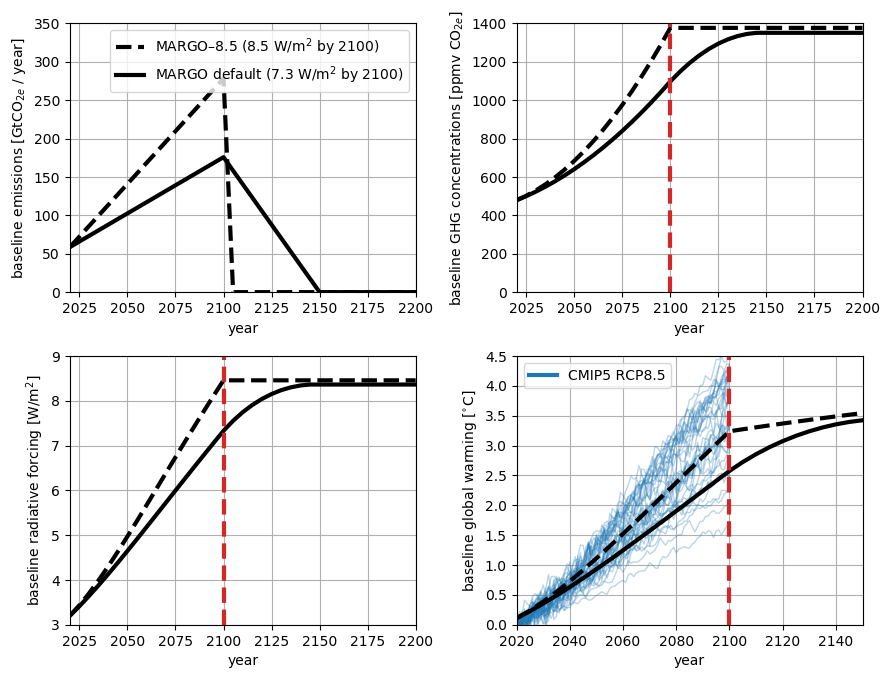

8.455142007641102
8.361028832768607


In [187]:
figure(figsize=(9,7))

subplot(2,2,4)

for i=1:40
    plot(time, gmst[:, i], "C0", lw=1., alpha=0.3)
end
plot([],[],"C0", label="CMIP5 RCP8.5")

RCP85_model = ClimateModel();
RCP85_model.economics.baseline_emissions = baseline_emissions(t::Array{Float64,1}, q0, 4.75, 2100., 2100.);
plot(RCP85_model.domain, δT(RCP85_model).-δT_init, "k--")
println(maximum(FCO₂_baseline(RCP85_model)/sec_per_year .+ 3.0))

model = ClimateModel();
model.economics.baseline_emissions = baseline_emissions(t);
plot(model.domain, δT(model).-δT_init, "k-")
println(maximum(FCO₂(model)/sec_per_year .+ 3.0))
xlim(2020, 2150)
ylim([0,4.5])
plot([2100, 2100], [0, 4.5], "C3--")
grid(true)
legend()
ylabel(L"baseline global warming [$^{\circ}$C]")
xlabel("year")

subplot(2,2,3)
plot(RCP85_model.domain, FCO₂(RCP85_model)/sec_per_year .+ 3.0, "k--")
plot(model.domain, FCO₂(model)/sec_per_year .+ 3.0, "k")
plot([2100, 2100], [3.0, 10], "C3--")
ylim([3, 9])
xlim([2020, 2200])
grid(true)
ylabel(L"baseline radiative forcing [W/m$^{2}$]")
xlabel("year")

subplot(2,2,2)
plot(RCP85_model.domain, CO₂(RCP85_model), "k--")
plot(model.domain, CO₂(model), "k")
plot([2100, 2100], [0, 1400], "C3--")
ylim([0, 1400])
xlim([2020, 2200])
grid(true)
ylabel(L"baseline GHG concentrations [ppmv CO$_{2e}$]")
xlabel("year")

subplot(2,2,1)
plot(RCP85_model.domain, ppm_to_GtCO2(RCP85_model.economics.baseline_emissions), "k--", label=L"MARGO–8.5 (8.5 W/m$^{2}$ by 2100)")
plot(model.domain, ppm_to_GtCO2(model.economics.baseline_emissions), "k", label=L"MARGO default (7.3 W/m$^{2}$ by 2100)")
ylim([0, 350])
xlim([2020, 2200])
grid(true)
legend()
ylabel(L"baseline emissions [GtCO$_{2e}$ / year]")
xlabel("year")

tight_layout()
savefig("../figures/CMIP5_RCP85_validation.png", dpi=200, bbox_inches="tight")